In [ ]:
# importing necessary packages
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
# Download test images
!wget --no-check-certificate https://drive.google.com/uc?id=1rz7OfWcmX05Sm6V-yT9CvIXkAx3d7SsW -O fruit.png
!wget --no-check-certificate https://drive.google.com/uc?id=1M_Vwimfmvi4E30H-wgqoROjoOQlAoupf -O shadow.png
!wget --no-check-certificate https://drive.google.com/uc?id=1X0CoCmsqauQjiZhiOT0JCmK1xCNPoxjK -O headCT.tif
!wget --no-check-certificate https://drive.google.com/uc?id=17QVp8qYIdcsPYEa_XLTlYsJTioNL16LZ -O ckt_board.tif
!wget --no-check-certificate https://drive.google.com/uc?id=1Xp-vJGaABDSEwqnaVRj_TQM_3ooWQYCK -O wallace_and_gromit.png
!wget --no-check-certificate https://drive.google.com/uc?id=1fiG1hGPl5Kpd2gEWPf-98bDaT4EXUFtD -O wood_dowels.tif
!wget --no-check-certificate https://drive.google.com/uc?id=17DNMzfE3Lc6B6ygU7Sf0DxP1VHx7-MNd -O board_with_noises.tif

--2024-11-06 19:42:09--  https://drive.google.com/uc?id=1rz7OfWcmX05Sm6V-yT9CvIXkAx3d7SsW
Resolving drive.google.com (drive.google.com)... 172.253.122.139, 172.253.122.102, 172.253.122.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1rz7OfWcmX05Sm6V-yT9CvIXkAx3d7SsW [following]
--2024-11-06 19:42:09--  https://drive.usercontent.google.com/download?id=1rz7OfWcmX05Sm6V-yT9CvIXkAx3d7SsW
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.179.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.179.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137047 (134K) [image/png]
Saving to: ‘fruit.png’

fruit.png           100%[===================>] 133.83K  --.-KB/s    in 0.02s   

2024-11-06 19:42:12 (5.67 MB/s) - ‘fruit.png’ 

# 1. Custom Implementation of Dilation and Erosion and Comparison with OpenCV Implementation

In [ ]:
import numpy as np

def grayscale_morphology(image, kernel, operation='dilation'):
    """
    Perform grayscale morphological operation (dilation or erosion) on an image using a given kernel.

    Parameters:
    - image: 2D numpy array representing the grayscale input image.
    - kernel: 2D numpy array representing the structuring element.
    - operation: 'dilation' or 'erosion' to specify the morphological operation.

    Returns:
    - output_image: 2D numpy array of the processed image after the morphological operation.
    """

    # Get the dimensions of the input image and the kernel
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate padding for the image, which is half the size of the kernel dimensions
    pad_y = kernel_height // 2
    pad_x = kernel_width // 2

    # Set the padding value and the aggregation function based on the operation type
    if operation == 'dilation':
        pad_value = 0              # For dilation, use 0 for padding
        aggregation_function = np.max  # Use max for dilation operation
    elif operation == 'erosion':
        pad_value = 255            # For erosion, use 255 for padding
        aggregation_function = np.min  # Use min for erosion operation
    else:
        raise ValueError("Operation must be 'dilation' or 'erosion'")  # Handle invalid operation type

    # Pad the image with the specified padding value for both height and width
    padded_image = np.pad(image, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=pad_value)

    # Create an empty array to store the result of the morphological operation
    output_image = np.zeros_like(image)

    # Apply the morphological operation on each pixel of the image
    for i in range(img_height):
        for j in range(img_width):
            # Extract the region of interest from the padded image that corresponds to the kernel's location
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            # Apply the aggregation function (either max for dilation or min for erosion) on the region
            output_image[i, j] = aggregation_function(region * kernel)

    return output_image

def grayscale_morphology_separable(image, kernel_size, operation='dilation'):
    """
    Perform separable grayscale morphological operation (dilation or erosion) on an image.
    The operation is performed first across rows and then across columns.

    Parameters:
    - image: 2D numpy array representing the grayscale input image.
    - kernel_size: Size of the kernel (must be an odd integer).
    - operation: 'dilation' or 'erosion' to specify the morphological operation.

    Returns:
    - row_processed: Image after row-wise processing.
    - output_image: Final output image after column-wise processing.
    """

    # Ensure kernel size is odd to maintain symmetry around the center pixel
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd")

    # Calculate padding for kernel based on its size
    pad = kernel_size // 2

    # Determine padding value and aggregation function based on operation type
    if operation == 'dilation':
        pad_value = 0
        aggregation_function = np.max  # Dilation uses max function
    elif operation == 'erosion':
        pad_value = 255
        aggregation_function = np.min  # Erosion uses min function
    else:
        raise ValueError("Operation must be 'dilation' or 'erosion'")

    # First pass: Apply the operation along the rows
    # Pad the image horizontally (width) only, preserving row height
    padded_image = np.pad(image, ((0, 0), (pad, pad)), mode='constant', constant_values=pad_value)

    # Array to store row-wise processed image
    row_processed = np.zeros_like(image)

    # Perform the row-wise operation
    for i in range(image.shape[0]):      # Iterate over rows
        for j in range(image.shape[1]):  # Iterate over columns within each row
            # Extract region from the padded image for the current row
            region = padded_image[i, j:j + kernel_size]
            # Apply the aggregation function across the row region
            row_processed[i, j] = aggregation_function(region)

    # Second pass: Apply the operation along columns using the row-processed image
    # Pad the row-processed image vertically (height) only, preserving column width
    padded_image = np.pad(row_processed, ((pad, pad), (0, 0)), mode='constant', constant_values=pad_value)

    # Array to store final output image after column-wise processing
    output_image = np.zeros_like(image)

    # Perform the column-wise operation
    for i in range(image.shape[0]):      # Iterate over rows
        for j in range(image.shape[1]):  # Iterate over columns within each row
            # Extract region from the padded image for the current column
            region = padded_image[i:i + kernel_size, j]
            # Apply the aggregation function across the column region
            output_image[i, j] = aggregation_function(region)

    return row_processed, output_image


Image height= 512 px, and width= 512 px and data type: uint8


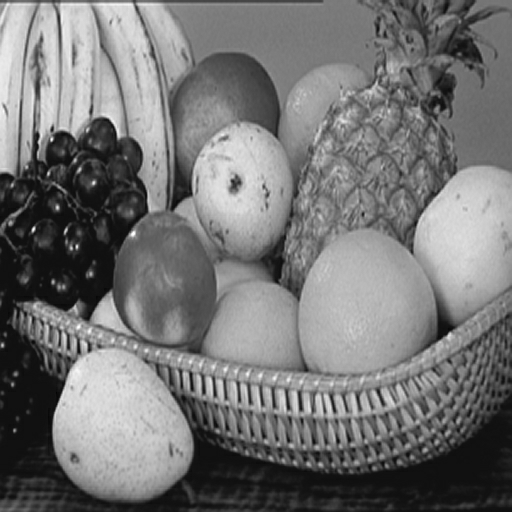

In [ ]:
image=cv2.imread('fruit.png',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

In [ ]:
# Define the size of the square structuring element (kernel) for morphological operations
kernel_size = 11

# Create a kernel (structuring element) as a matrix of ones with the specified size.
# This will be used to determine the neighborhood for the morphological operations.
kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

# Perform custom grayscale dilation on the image using the defined kernel
# Dilation increases the white regions in the image by applying the maximum value in the neighborhood.
dilated_image = grayscale_morphology(image, kernel, operation='dilation')

# Perform custom grayscale erosion on the image using the defined kernel
# Erosion shrinks the white regions by applying the minimum value in the neighborhood.
eroded_image = grayscale_morphology(image, kernel, operation='erosion')

# Perform dilation using OpenCV's built-in function, which is optimized for speed
# The same kernel is used here, with one iteration of the dilation process.
dilated_image_cv2 = cv2.dilate(image, kernel, iterations=1)

# Perform erosion using OpenCV's built-in function, also with one iteration
# This will result in a similar output to `grayscale_morphology(image, kernel, operation='erosion')`.
eroded_image_cv2 = cv2.erode(image, kernel, iterations=1)

# Perform a separable grayscale dilation using the custom separable function
# This function applies dilation first along rows, then along columns, to optimize computation.
# The separable approach splits dilation into two stages:
#   - `dilated_image_1d` stores the result after processing rows.
#   - `dilated_image_2d` stores the final result after processing columns.
dilated_image_1d, dilated_image_2d = grayscale_morphology_separable(image, kernel_size, operation='dilation')

# Similarly, perform separable grayscale erosion using the custom separable function
# This applies erosion in two stages, first across rows and then across columns.
#   - `eroded_image_1d` stores the row-wise result.
#   - `eroded_image_2d` stores the final result after column-wise processing.
eroded_image_1d, eroded_image_2d = grayscale_morphology_separable(image, kernel_size, operation='erosion')


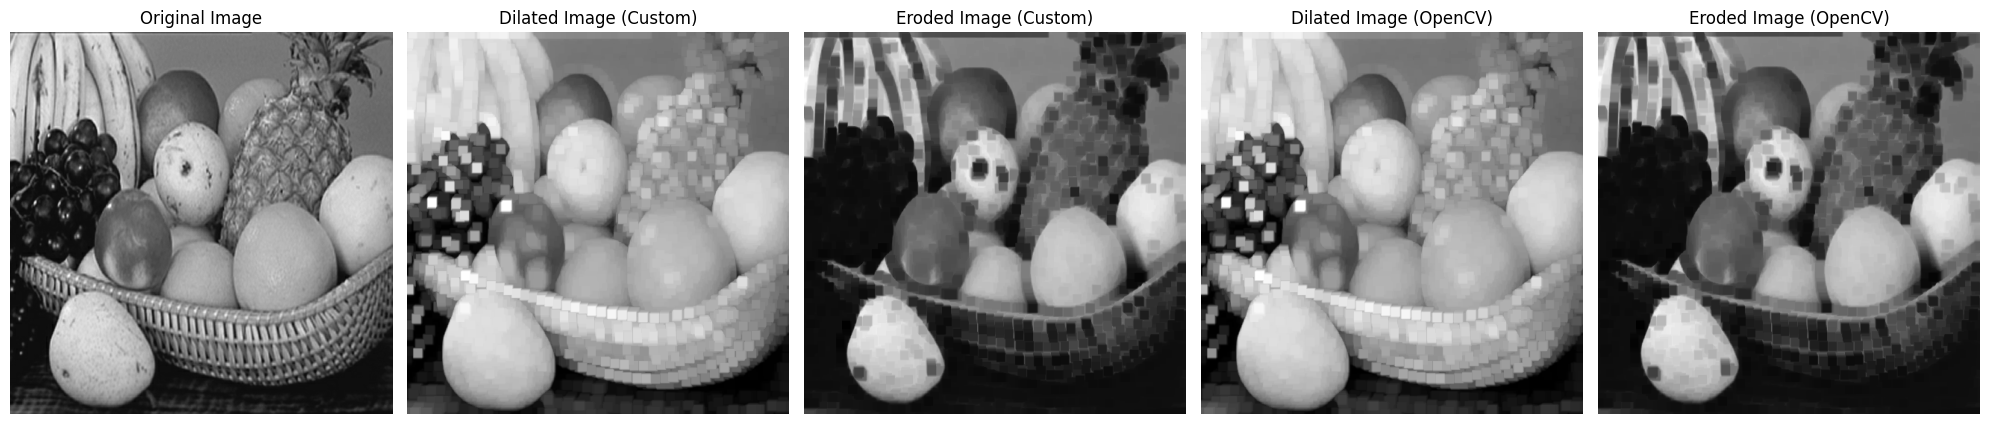

In [ ]:
# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image (Custom)')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(eroded_image, cmap='gray')
plt.title('Eroded Image (Custom)')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(dilated_image_cv2, cmap='gray')
plt.title('Dilated Image (OpenCV)')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(eroded_image_cv2, cmap='gray')
plt.title('Eroded Image (OpenCV)')
plt.axis('off')

plt.tight_layout()
plt.show()

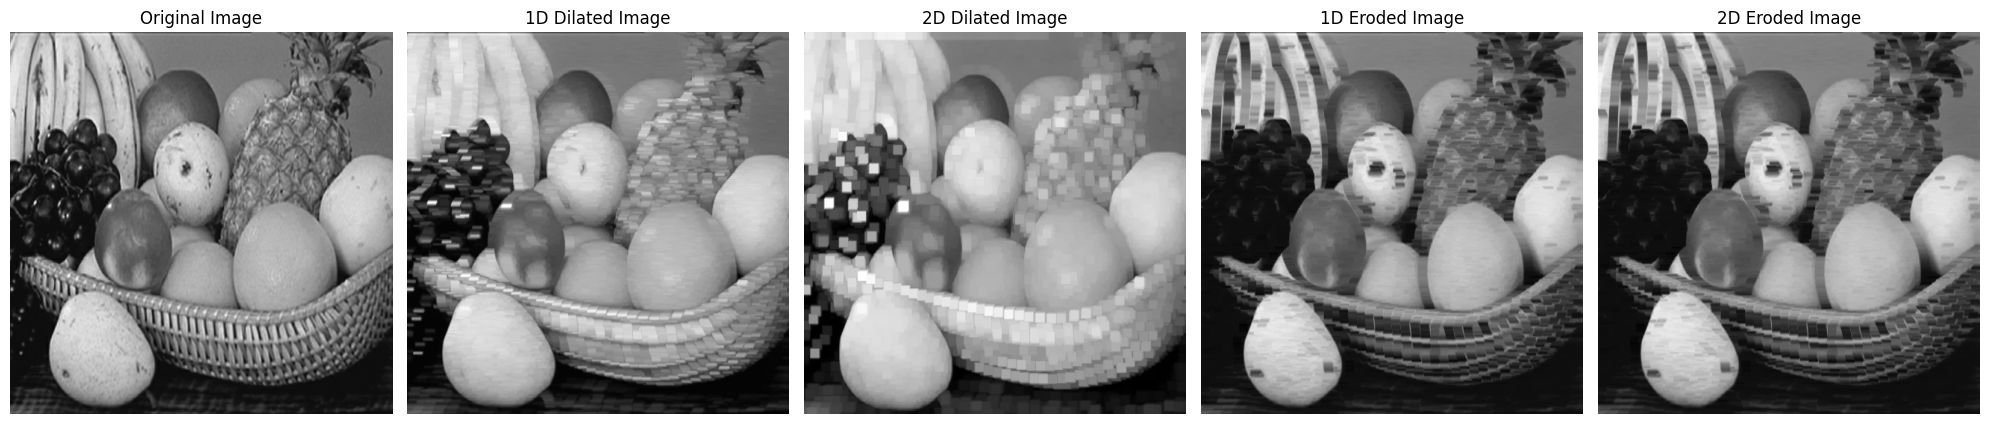

In [ ]:
# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(dilated_image_1d, cmap='gray')
plt.title('1D Dilated Image')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(dilated_image_2d, cmap='gray')
plt.title('2D Dilated Image')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(eroded_image_1d, cmap='gray')
plt.title('1D Eroded Image')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(eroded_image_1d, cmap='gray')
plt.title('2D Eroded Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# 2. Morphological Gradient

Image height= 512 px, and width= 512 px and data type: uint8


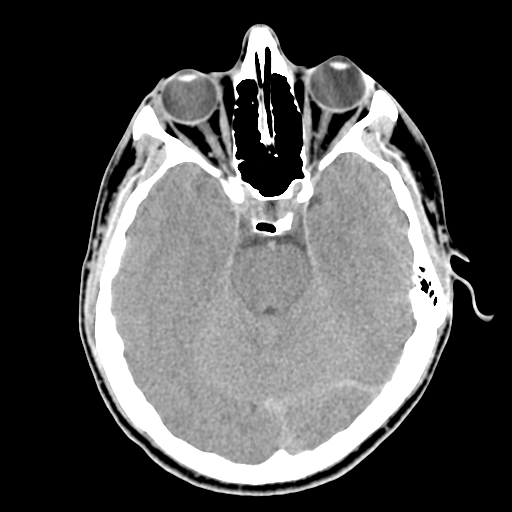

In [ ]:
# Load a grayscale image
image = cv2.imread('headCT.tif', cv2.IMREAD_GRAYSCALE)

# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

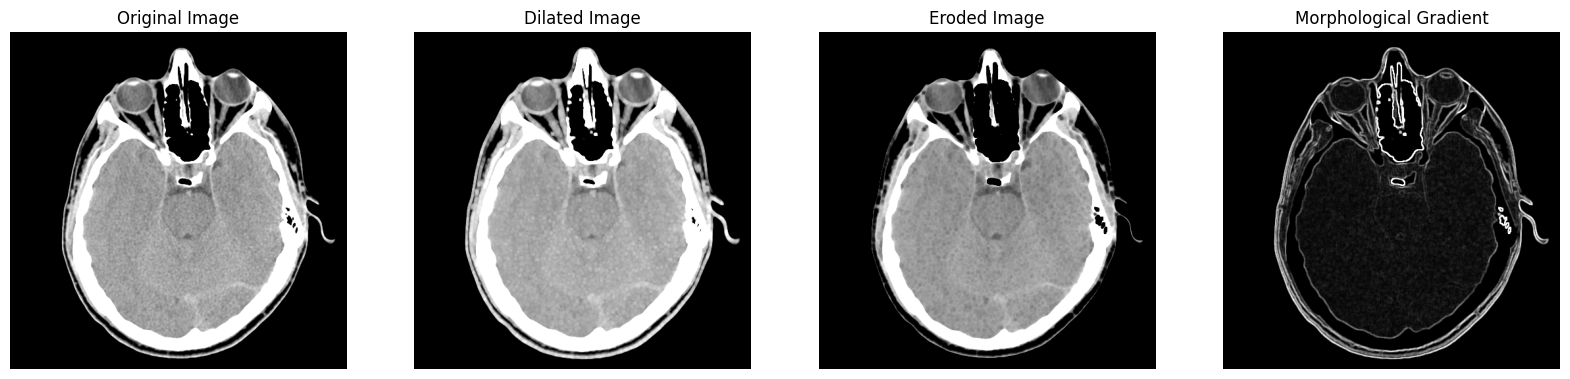

In [ ]:
# Define a structuring element (e.g., a 3x3 square)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# Perform Dilation
dilated_image = cv2.dilate(image, structuring_element)

# Perform Erosion
eroded_image = cv2.erode(image, structuring_element)

# Calculate the Morphological Gradient (Dilation - Erosion)
morphological_gradient = cv2.subtract(dilated_image, eroded_image)

# Display the original image and the Morphological Gradient
plt.figure(figsize=(20, 10))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Dilated Image
plt.subplot(1, 4, 2)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')

# Dilated Image
plt.subplot(1, 4, 3)
plt.imshow(eroded_image, cmap='gray')
plt.title('Eroded Image')
plt.axis('off')

# Morphological Gradient
plt.subplot(1, 4, 4)
plt.imshow(morphological_gradient, cmap='gray')
plt.title('Morphological Gradient')
plt.axis('off')

plt.show()


# 3. Graysacle opening and closing example

Image height= 448 px, and width= 425 px and data type: uint8


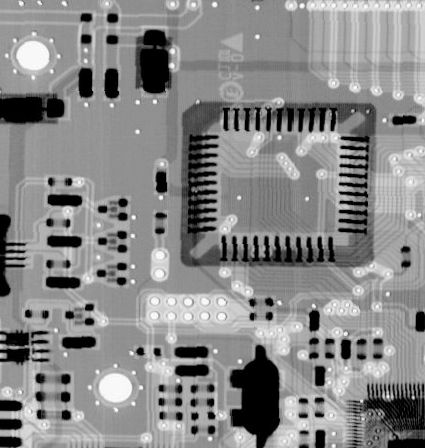

In [ ]:
image=cv2.imread('ckt_board.tif',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

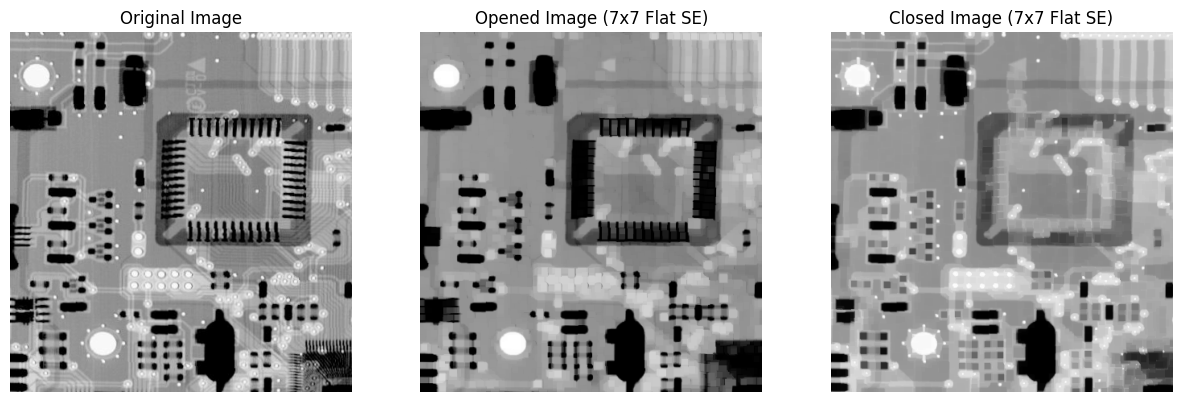

In [ ]:
# Define a structuring element (e.g., a 5x5 square)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))

# Perform Opening (Erosion followed by Dilation)
opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, structuring_element)

# Perform Closing (Dilation followed by Erosion)
closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, structuring_element)

plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Opened Image
plt.subplot(1, 3, 2)
plt.imshow(opened_image, cmap='gray')
plt.title('Opened Image (7x7 Flat SE)')
plt.axis('off')

# Closed Image
plt.subplot(1, 3, 3)
plt.imshow(closed_image, cmap='gray')
plt.title('Closed Image (7x7 Flat SE)')
plt.axis('off')

plt.show()

# 4. TopHat vs. BotHat

Image height= 444 px, and width= 443 px and data type: uint8


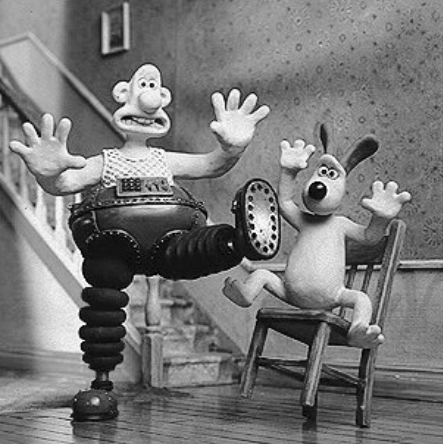

In [ ]:
image=cv2.imread('wallace_and_gromit.png',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

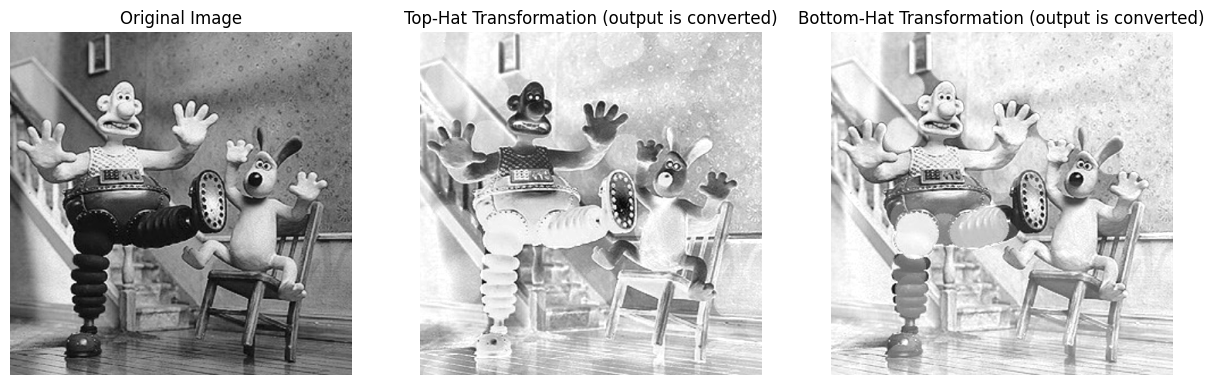

In [ ]:
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (41,41))

# Perform Top-Hat Transformation (Original - Opening)
top_hat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuring_element)

# Perform Bottom-Hat Transformation (Closing - Original)
bottom_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuring_element)

# Display the original image, Top-Hat, and Bottom-Hat transformations
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Top-Hat Transformation
plt.subplot(1, 3, 2)
plt.imshow(255 - top_hat, cmap='gray')
plt.title('Top-Hat Transformation (output is converted)')
plt.axis('off')

# Bottom-Hat Transformation
plt.subplot(1, 3, 3)
plt.imshow(255 - bottom_hat, cmap='gray')
plt.title('Bottom-Hat Transformation (output is converted)')
plt.axis('off')

plt.show()

# 4. Top-hat tranformation for shading correction

Image height= 391 px, and width= 402 px and data type: uint8


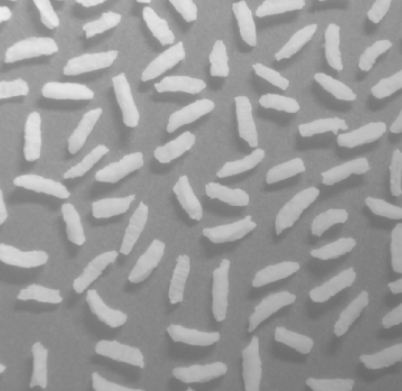

In [ ]:
image=cv2.imread('shadow.png',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

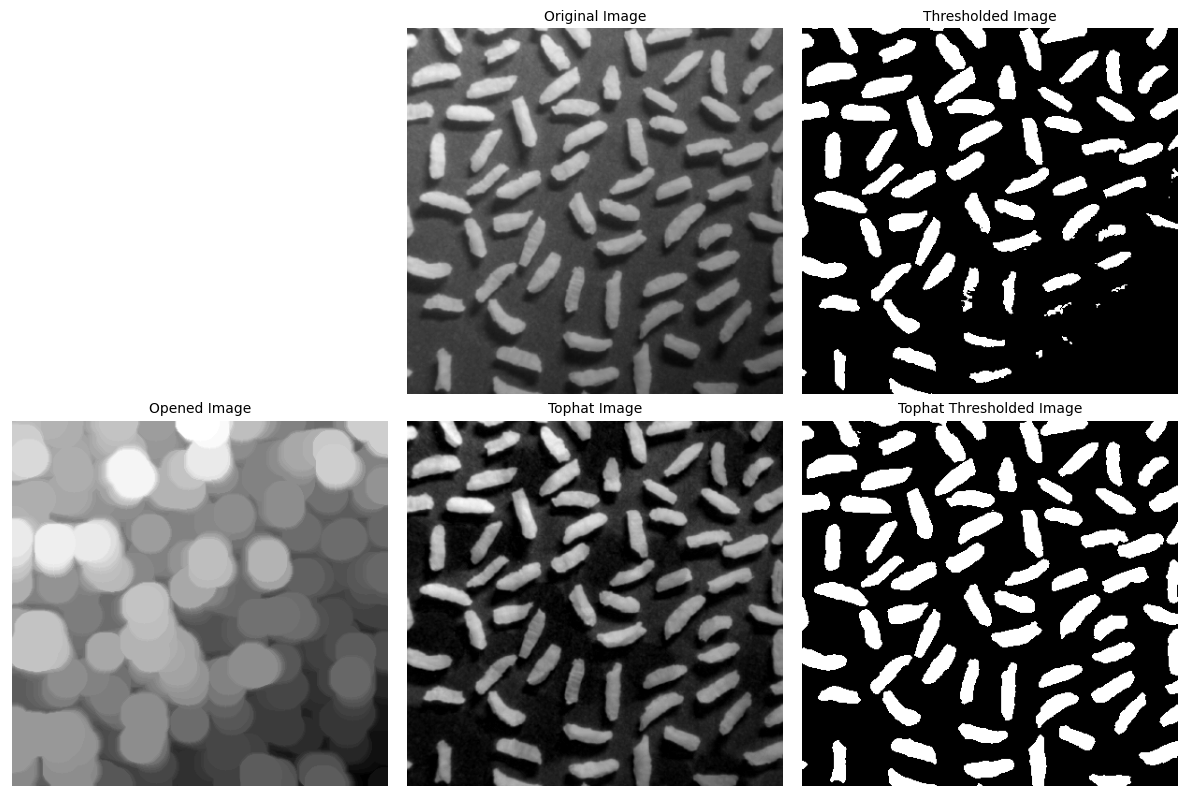

In [ ]:
ret, thresholded_image = cv2.threshold(image, 175, 255, cv2.THRESH_BINARY)

opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40)))

tophat_image = cv2.subtract(image, opened_image)

ret, tophat_thresholded_image = cv2.threshold(tophat_image, 30, 255, cv2.THRESH_BINARY)

images = [image, thresholded_image, opened_image, tophat_image, tophat_thresholded_image]
descriptions = ['Original Image', 'Thresholded Image', 'Opened Image', 'Tophat Image', 'Tophat Thresholded Image']

# Create a figure with a grid of 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Turn off axes in the grid for centering purposes in the first row
axes[0, 0].axis('off')
axes[0, 2].axis('off')

# Display the first two images centered in the first row
axes[0, 1].imshow(images[0], cmap='gray')
axes[0, 1].set_title(descriptions[0], fontsize=10)
axes[0, 1].axis('off')  # Hide axis for clean display

axes[0, 2].imshow(images[1], cmap='gray')
axes[0, 2].set_title(descriptions[1], fontsize=10)
axes[0, 2].axis('off')  # Hide axis for clean display

# Display the next three images in the second row
for i in range(3):
    axes[1, i].imshow(images[i + 2], cmap='gray')
    axes[1, i].set_title(descriptions[i+2], fontsize=10)
    axes[1, i].axis('off')  # Hide axis for clean display

plt.tight_layout()
plt.show()

# 5. Granulometry

Image height= 531 px, and width= 675 px and data type: uint8


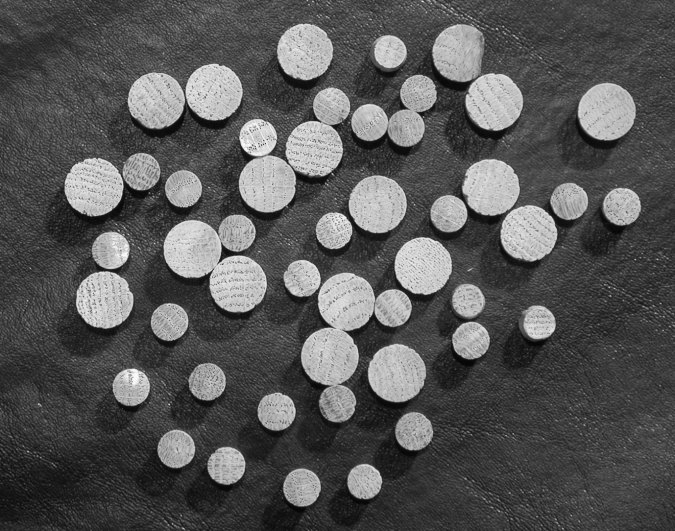

In [ ]:
image=cv2.imread('wood_dowels.tif',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

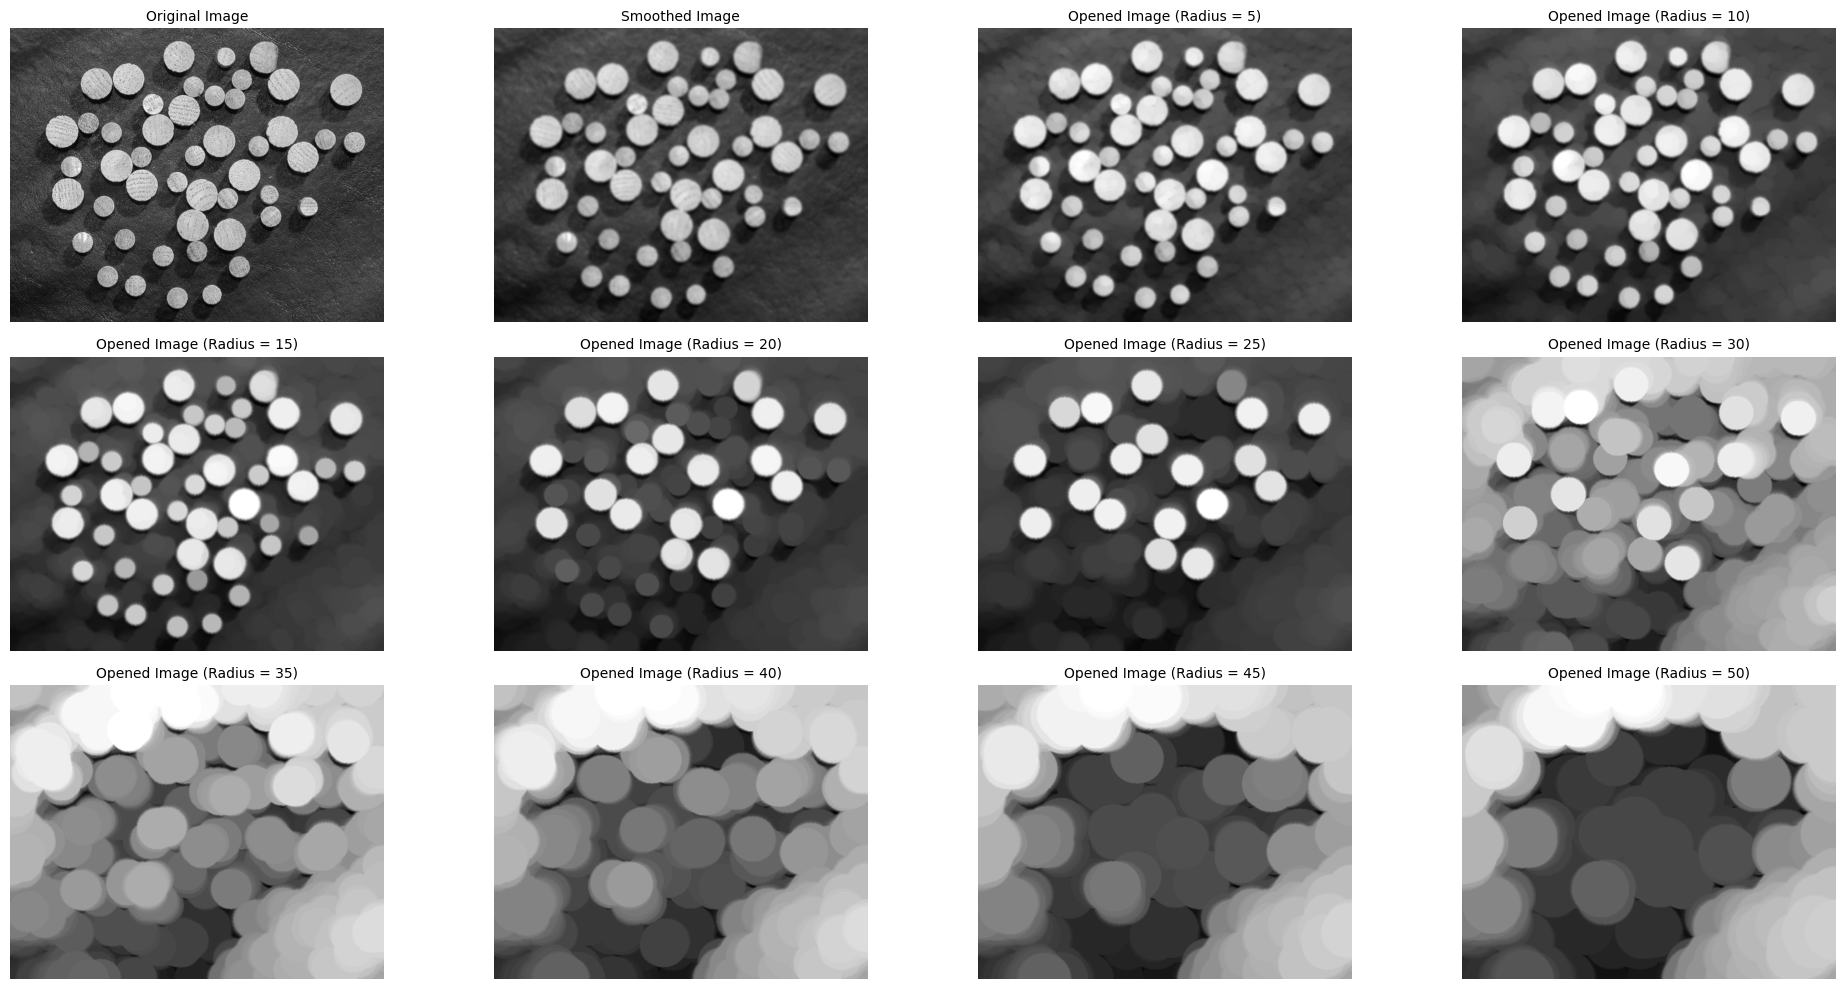

In [ ]:

smoothed_image = cv2.GaussianBlur(image, (11, 11), 0)

images = [image, smoothed_image]
descriptions = ['Original Image', 'Smoothed Image']

radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
totalPixels = []

# (c)-(f) Apply morphological opening with disks of different radii
for i, radius in enumerate(radii, start=3):
    # Create a disk-shaped structuring element
    struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

    # Perform opening on the smoothed image
    opened_image = cv2.morphologyEx(smoothed_image, cv2.MORPH_OPEN, struct_elem)
    totalPixels.append(np.sum(opened_image))
    images.append(opened_image)
    descriptions.append(f'Opened Image (Radius = {radius})')

# Create a figure with a grid of 2 rows and 6 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 10))


for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  # Display the image in grayscale
    ax.set_title(descriptions[i], fontsize=10)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


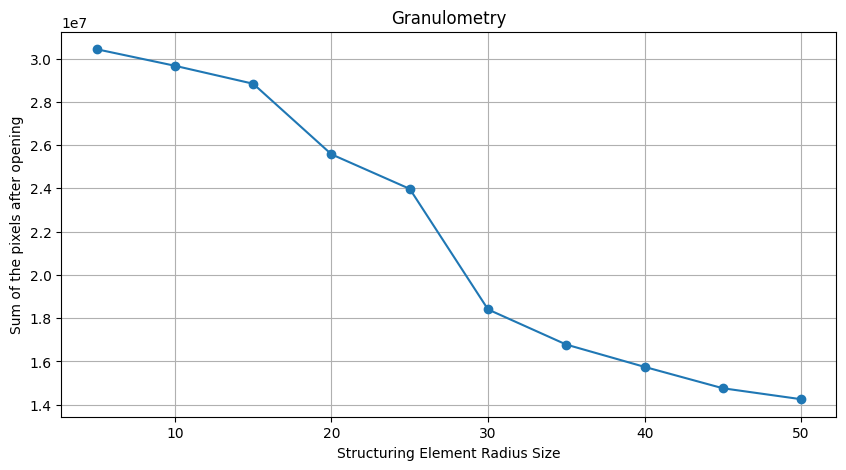

In [ ]:
# Plotting the granulometry
plt.figure(figsize=(10, 5))
plt.plot(radii, totalPixels, marker='o')
plt.title('Granulometry')
plt.xlabel('Structuring Element Radius Size')
plt.ylabel('Sum of the pixels after opening')
plt.grid(True)
plt.show()

# 6. Noise Reduction

Image height= 440 px, and width= 455 px and data type: uint8


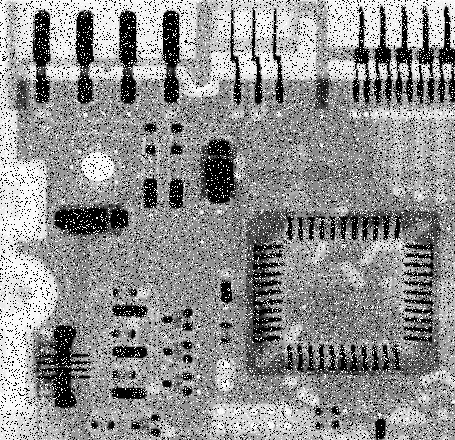

In [ ]:
image=cv2.imread('board_with_noises.tif',cv2.IMREAD_GRAYSCALE)
# pring image properties
height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

cv2_imshow(image)

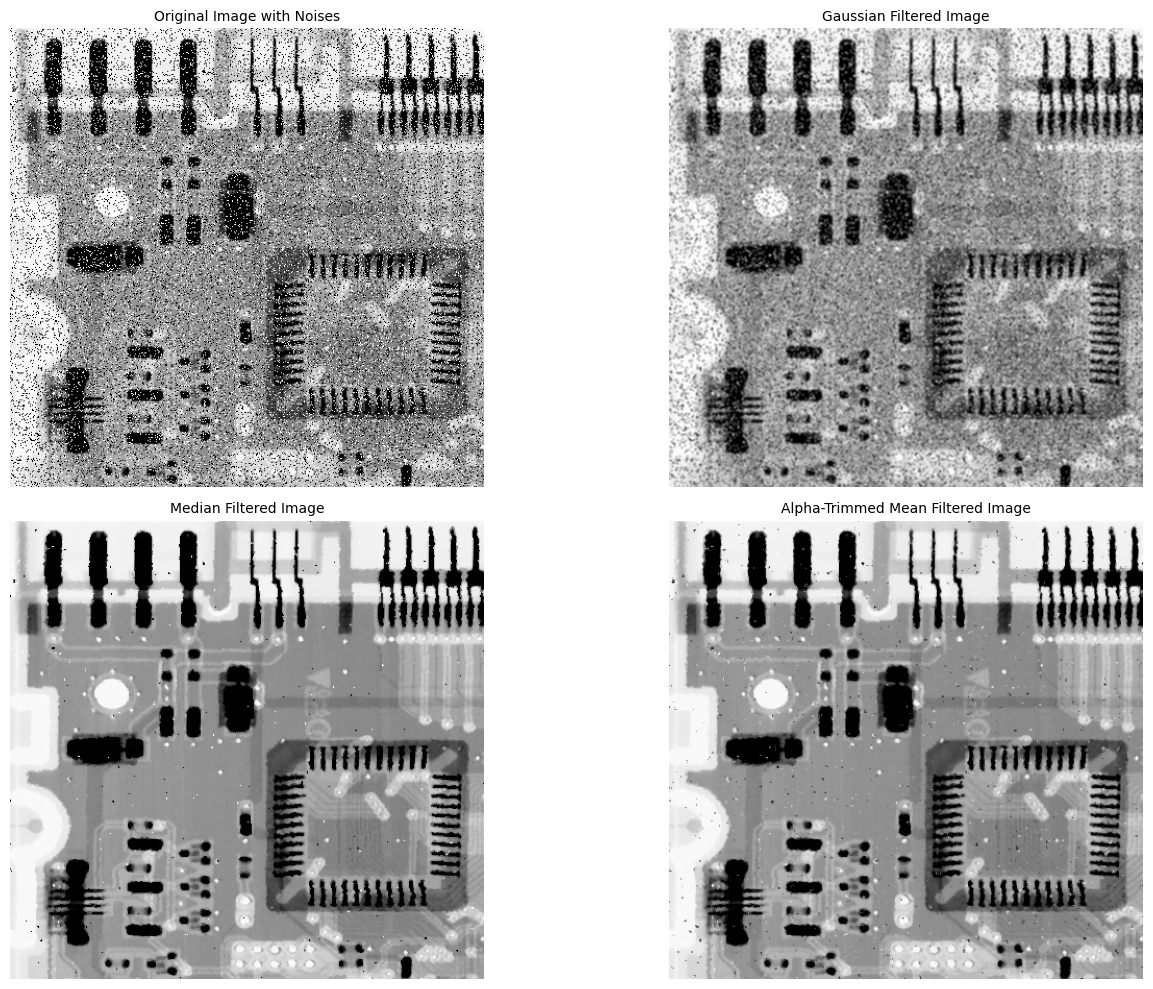

In [ ]:

def alpha_trimmed_mean_filter(image, kernel_size=3, alpha=0.2):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')
    output_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract the kernel window
            window = padded_image[i:i + kernel_size, j:j + kernel_size].flatten()
            sorted_window = np.sort(window)

            # Trim alpha fraction from both ends
            trim = int(alpha * len(sorted_window) / 2)
            trimmed_window = sorted_window[trim:len(sorted_window) - trim]

            # Calculate the mean of the trimmed window
            output_image[i, j] = np.mean(trimmed_window)

    return output_image.astype(np.uint8)

median_filtered_image = cv2.medianBlur(image, 3)
alpha_trimmed_mean_filtered_image = alpha_trimmed_mean_filter(image, kernel_size=3, alpha=0.8)
gaussion_filtered_image = cv2.GaussianBlur(image, (3, 3), 1.0)


images = [image, gaussion_filtered_image, median_filtered_image, alpha_trimmed_mean_filtered_image]
descriptions = ['Original Image with Noises', 'Gaussian Filtered Image', 'Median Filtered Image', 'Alpha-Trimmed Mean Filtered Image']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))


for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(descriptions[i], fontsize=10)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()